## Import Libraries ##

In [2]:
import os
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin
from osgeo import gdal, osr
import geopandas as gpd
from shapely.geometry import Point, Polygon, shape
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from tqdm import tqdm
from rasterio.features import geometry_window, shapes, geometry_mask
from rasterio.warp import reproject, Resampling
from rasterio.enums import Resampling
from scipy.interpolate import griddata

## Define Filepaths ##

In [3]:
BASE_DIR = 'C:\\Users\\chris\\Desktop\\use-of-AI-to-eradicate-extreme-poverty'
SETTLEMENT_DIRS = [
    os.path.join(BASE_DIR, 'data/GlobalHumanSettlement/GHS_BUILT_S_E2020_GLOBE_R2023A_54009_100_V1_0_R11_C22.tif'),
    os.path.join(BASE_DIR, 'data/GlobalHumanSettlement/GHS_BUILT_S_E2020_GLOBE_R2023A_54009_100_V1_0_R12_C22.tif')
]
NIGHTLIGHTS_DIR = os.path.join(BASE_DIR, 'data', 'nightlights', 'viirs_2020_00N060W.tif')
ROADS_DIR = os.path.join(BASE_DIR, 'data', 'roads', 'GRIP4_density_total','grip4_total_dens_m_km2.asc')
HEALTH_DIR = os.path.join(BASE_DIR, 'data', 'health_facilities', 'healthcare_2020.shp')
LSMS_DIR = os.path.join(BASE_DIR, 'data', 'LSMS_2019')
csv_file_path = os.path.join(LSMS_DIR, 'HouseholdGeovariables_csv', 'householdgeovariables_ihs5.csv')

In [4]:
df = pd.read_csv(csv_file_path) ## to read  the LSMS data csvs

## IDW Interpolation of gap_poor point data ##

In [5]:
def interpolate_raster_from_points(points_shp_path, boundary_shp_path, output_raster_path, data_column='gap_poor', cell_size=100, no_data_value=-9999):
    try:
        print("Loading point data...")
        points = gpd.read_file(points_shp_path)
        boundary = gpd.read_file(boundary_shp_path)

        if points.crs.is_geographic:
            print("Transforming to a projected CRS...")
            points = points.to_crs(epsg=3857)

        if boundary.crs != points.crs:
            print("Transforming boundary to the same CRS as points...")
            boundary = boundary.to_crs(points.crs)

        bounds = boundary.total_bounds
        print(f"Bounds for interpolation: {bounds}")

        minx, miny, maxx, maxy = bounds
        width = int((maxx - minx) / cell_size)
        height = int((maxy - miny) / cell_size)
        transform = from_origin(minx, maxy, cell_size, cell_size)

        print("Preparing grid coordinates for interpolation...")
        x_coords = np.linspace(minx, maxx, num=width, endpoint=True)
        y_coords = np.linspace(maxy, miny, num=height, endpoint=True)
        grid_x, grid_y = np.meshgrid(x_coords, y_coords, indexing='xy')

        print("Extracting point coordinates and values...")
        points_coords = np.vstack((points.geometry.x, points.geometry.y)).T
        points_values = points[data_column].values

        print("Performing interpolation...")
        grid_points = np.column_stack((grid_x.ravel(), grid_y.ravel()))
        interpolated_values = griddata(points_coords, points_values, grid_points, method='linear', fill_value=no_data_value).reshape(height, width)

        print("Creating mask from boundary polygon...")
        mask = geometry_mask([geom for geom in boundary.geometry], out_shape=(height, width), transform=transform, invert=True)
        interpolated_values[~mask] = no_data_value

        # visualization
        fig, ax = plt.subplots(figsize=(10, 10))
        boundary.plot(ax=ax, color='blue', alpha=0.3, edgecolor='k')
        ax.scatter(points.geometry.x, points.geometry.y, color='red', s=10)  # Points
        ax.imshow(interpolated_values, extent=[minx, maxx, miny, maxy], origin='lower', alpha=0.5, cmap='viridis')
        plt.show()

        out_meta = {
            'driver': 'GTiff',
            'height': height,
            'width': width,
            'transform': transform,
            'crs': points.crs.to_string(),
            'dtype': 'float32',
            'count': 1,
            'nodata': no_data_value
        }

        print("Writing the output raster...")
        with rasterio.open(output_raster_path, 'w', **out_meta) as dst:
            dst.write(interpolated_values, 1)
        print("Raster interpolation complete and file written successfully to", output_raster_path)

    except Exception as e:
        import traceback
        traceback.print_exc()
        print("An error occurred:", e)

In [6]:
points_shp_path = os.path.join(BASE_DIR, 'results', 'shapefiles', 'df_mw_points.shp')
boundary_shp_path = os.path.join(BASE_DIR, 'data', 'borders', 'malawi_no_lake.shp')
raster_template_path = os.path.join(BASE_DIR, 'results', 'rasters', 'settlements_merged.tif')
output_raster_path = os.path.join(BASE_DIR, 'results', 'rasters', 'interpolation_gap_poor.tif')

Loading point data...
Transforming to a projected CRS...
Transforming boundary to the same CRS as points...
Bounds for interpolation: [ 3636062.83005719 -1936199.31511448  3996848.27682162 -1049011.9383619 ]
Preparing grid coordinates for interpolation...
Extracting point coordinates and values...
Performing interpolation...
Creating mask from boundary polygon...


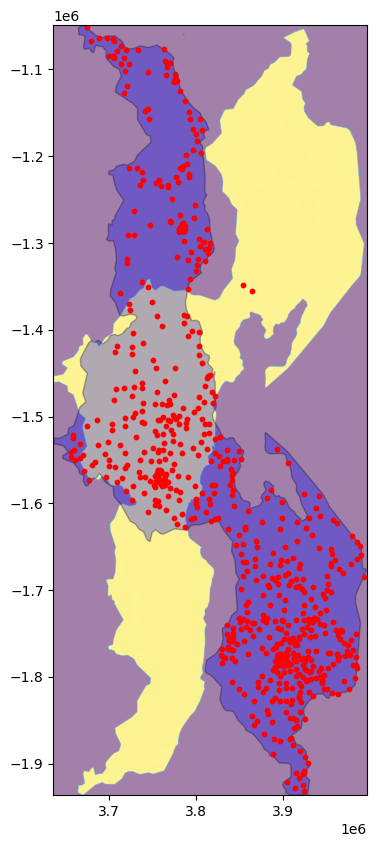

Writing the output raster...
Raster interpolation complete and file written successfully to C:\Users\chris\Desktop\use-of-AI-to-eradicate-extreme-poverty\results\rasters\interpolation_gap_poor.tif


In [7]:
# call interpolation function
interpolate_raster_from_points(points_shp_path, boundary_shp_path, output_raster_path, data_column='gap_poor', cell_size=100, no_data_value=-9999)

In [8]:
def create_boundary_shapefile_from_raster(raster_path, output_shapefile_path):
    with rasterio.open(raster_path) as src:
        mask = src.dataset_mask()
        shapes_list = list(shapes(mask, transform=src.transform))
        geometries = [shape(geom) for geom, value in shapes_list if value == 255]
        gdf = gpd.GeoDataFrame({"geometry": geometries}, crs=src.crs)
        gdf.to_file(output_shapefile_path)

interpolated_raster_path = os.path.join(BASE_DIR, 'results', 'rasters', 'interpolation_gap_poor.tif')
output_shapefile_path = os.path.join(BASE_DIR, 'results', 'shapefiles', 'interpolated_raster_boundary.shp')
create_boundary_shapefile_from_raster(interpolated_raster_path, output_shapefile_path)

In [10]:
import os
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling

def align_and_save_rasters(target_raster_path, raster_paths, output_paths):
    with rasterio.open(target_raster_path) as target_raster:
        target_transform = target_raster.transform
        target_crs = target_raster.crs
        target_width = target_raster.width
        target_height = target_raster.height

        for to_align_raster_path, output_path in zip(raster_paths, output_paths):
            with rasterio.open(to_align_raster_path) as to_align_raster:
                aligned_array = np.empty((target_height, target_width), dtype=to_align_raster.dtypes[0])
                nodata = to_align_raster.nodata

                reproject(
                    source=rasterio.band(to_align_raster, 1),
                    destination=aligned_array,
                    src_transform=to_align_raster.transform,
                    src_crs=to_align_raster.crs,
                    dst_transform=target_transform,
                    dst_crs=target_crs,
                    dst_width=target_width,
                    dst_height=target_height,
                    resampling=Resampling.nearest,  # Changed to nearest for preserving extremes
                    src_nodata=nodata,  # Ensuring nodata is considered
                    dst_nodata=nodata  # Propagate nodata to destination
                )

                # ensure no negative values in the nightlights raster
                if 'nightlights' in to_align_raster_path:
                    aligned_array[aligned_array < 0] = 0  # Set negative values to zero

                # save the aligned raster to disk
                new_raster_meta = to_align_raster.meta.copy()
                new_raster_meta.update({
                    'driver': 'GTiff',
                    'height': target_height,
                    'width': target_width,
                    'transform': target_transform,
                    'crs': target_crs,
                    'nodata': nodata  # Make sure to include nodata in meta
                })

                with rasterio.open(output_path, 'w', **new_raster_meta) as dst_raster:
                    dst_raster.write(aligned_array, 1)

# call function 
BASE_DIR = r'C:\Users\chris\Desktop\use-of-AI-to-eradicate-extreme-poverty'
target_raster_path = os.path.join(BASE_DIR, 'results', 'rasters', 'interpolation_gap_poor.tif')
raster_paths = [
    os.path.join(BASE_DIR, 'data', 'nightlights', 'viirs_2020_00N060W.tif'),
    os.path.join(BASE_DIR, 'results', 'rasters', 'settlements_merged.tif'),
    os.path.join(BASE_DIR, 'data', 'roads', 'GRIP4_density_total', 'grip4_total_dens_m_km2_4326.tif'),
    os.path.join(BASE_DIR, 'results', 'rasters', 'healthcare_density.tif')
]
output_paths = [
    os.path.join(BASE_DIR, 'results', 'rasters', 'aligned_nightlights.tif'),
    os.path.join(BASE_DIR, 'results', 'rasters', 'aligned_settlements.tif'),
    os.path.join(BASE_DIR, 'results', 'rasters', 'aligned_roads_density.tif'),
    os.path.join(BASE_DIR, 'results', 'rasters', 'aligned_healthcare.tif')
]

# Call the function
align_and_save_rasters(target_raster_path, raster_paths, output_paths)

In [11]:
# Load the aligned rasters to check their shapes
aligned_nightlights_path = os.path.join(BASE_DIR, 'results', 'rasters', 'aligned_nightlights.tif')
aligned_settlements_path = os.path.join(BASE_DIR, 'results', 'rasters', 'aligned_settlements.tif')
aligned_roads_density_path = os.path.join(BASE_DIR, 'results', 'rasters', 'aligned_roads_density.tif')
aligned_healthcare_path = os.path.join(BASE_DIR, 'results', 'rasters', 'aligned_healthcare.tif')
interpolated_raster_path = os.path.join(BASE_DIR, 'results', 'rasters', 'interpolation_gap_poor.tif')

with rasterio.open(aligned_nightlights_path) as aligned_nightlights:
    print("Aligned Nightlights Shape:", aligned_nightlights.shape)

with rasterio.open(aligned_settlements_path) as aligned_settlements:
    print("Aligned Settlements Shape:", aligned_settlements.shape)

with rasterio.open(aligned_roads_density_path) as aligned_roads_density:
    print("Aligned Roads Density Shape:", aligned_roads_density.shape)

with rasterio.open(aligned_healthcare_path) as aligned_healthcare:
    print("Aligned Healthcare Shape:", aligned_healthcare.shape)

with rasterio.open(interpolated_raster_path) as interpolation_gap_poor:
    print("Interpolartion raster Shape:", interpolation_gap_poor.shape)

Aligned Nightlights Shape: (8871, 3607)
Aligned Settlements Shape: (8871, 3607)
Aligned Roads Density Shape: (8871, 3607)
Aligned Healthcare Shape: (8871, 3607)
Interpolartion raster Shape: (8871, 3607)
